In [82]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import (
    PowerTransformer,
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_val_score
)
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE, ADASYN

In [12]:
# Read in the dataset
df = pd.read_csv("../data/ML Assessment Dataset (Bank Data) - Sheet1.csv")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [3]:
# Define the columns
binary_cols = {
    "default", 
    "housing",
    "loan",
    "y"
}

cat_cols = {
    "job",
    "marital",
    "education", # ordinal
    "contact",
    "month",
    "poutcome"
}

num_cols = {
    "age",
    "balance",
    "day",
    "duration",
    "campaign",
    "pdays",
    "previous"
}

In [13]:
# Convert the binary columns to 0 and 1
for col in binary_cols:
    df[col] = df[col].map({"yes": 1, "no": 0})

# Data Split

In [29]:
# Split the dataset into train and test
train_data, test_data = train_test_split(df,
                                         test_size=0.2,
                                         random_state=42,
                                         stratify=df["y"])
# Check the shape of the data
train_data.shape, test_data.shape

((3616, 17), (905, 17))

In [31]:
# Define the columns for the imbalanced columns
imbalanced_num_cols = [
    "balance",
    "campaign",
    "duration"
]

# Define the transformation function
pt = PowerTransformer(method='yeo-johnson')
train_data[imbalanced_num_cols] = pt.fit_transform(train_data[imbalanced_num_cols])

# Apply the transformation on the test data
test_data[imbalanced_num_cols] = pt.transform(test_data[imbalanced_num_cols])

In [19]:
# Save the Transformer for inference
joblib.dump(pt, "../artifacts/pt.pkl")

['../artifacts/pt.pkl']

# Categorical Data Encoding

In [32]:
# Define the columns for One hot encoder
ohe_cols = [
    "job",
    "marital",
    "contact",
    "poutcome",
    "month"
]

# Define the One Hot Encoder
ohe = OneHotEncoder(drop="first", handle_unknown='ignore')

# Fit and get the encoded data
encoded_data = ohe.fit_transform(train_data[ohe_cols])

# Create a separate dataframe for the encoded data
encoded_df = pd.DataFrame(encoded_data.toarray(), columns=ohe.get_feature_names_out(ohe_cols))

# Concatenate the encoded data with the original data
train_data = pd.concat([train_data.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

# Drop the original columns
train_data.drop(ohe_cols, axis=1, inplace=True)

# Check the shape of the data
train_data.shape

(3616, 41)

In [33]:
# Transform the test data
encoded_data = ohe.transform(test_data[ohe_cols])

# Create a separate dataframe for the encoded data
encoded_df = pd.DataFrame(encoded_data.toarray(), columns=ohe.get_feature_names_out(ohe_cols))

# Concatenate the encoded data with the original data
test_data = pd.concat([test_data.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

# Drop the original columns
test_data.drop(ohe_cols, axis=1, inplace=True)

# Check the shape of the data
test_data.shape

(905, 41)

In [20]:
# Save the One Hot Encoder for inference
joblib.dump(ohe, "../artifacts/ohe.pkl")

['../artifacts/ohe.pkl']

In [34]:
# Define the Ordinal Encoder
oe = OrdinalEncoder()

# Fit and get the encoded data
train_data["education"] = oe.fit_transform(train_data[["education"]])

# Transform the test data
test_data["education"] = oe.transform(test_data[["education"]])

# Check the shape of the data
train_data["education"].shape

(3616,)

In [21]:
# Save the Ordinal Encoder for inference
joblib.dump(oe, "../artifacts/oe.pkl")

['../artifacts/oe.pkl']

# Numerical Data Scaling

In [35]:
# Define the Standard Scaler
ss = StandardScaler()

# Fit and get the encoded data
train_data[list(num_cols)] = ss.fit_transform(train_data[list(num_cols)])

# Transform the test data
test_data[list(num_cols)] = ss.transform(test_data[list(num_cols)])

In [25]:
# Save the Standard Scaler for inference
joblib.dump(ss, "../artifacts/ss.pkl")

['../artifacts/ss.pkl']

# Model Training and Evaluation

## Model 1: Decision Tree

In [36]:
# Define the decision tree classifier
decision_tree_clf = DecisionTreeClassifier(random_state=42)

# Define hyperparameters to search over
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a grid search cross-validation object
grid_search = GridSearchCV(decision_tree_clf, param_grid, cv=5)

# Fit the grid search to the data
X_train = train_data.drop("y", axis=1)
y_train = train_data["y"]
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10, 15, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]})

In [39]:
# Get the best hyperparameters
best_params = grid_search.best_params_

# Get the best model
best_model = grid_search.best_estimator_


print(f"The best model is: {best_model}, and the parameters are: \n{best_params}")

The best model is: DecisionTreeClassifier(max_depth=5, min_samples_leaf=2, random_state=42), and the parameters are: 
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}


In [43]:
# Evaluate the best model on the train set
y_pred = best_model.predict(X_train)
report = classification_report(y_train, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      3199
           1       0.81      0.42      0.56       417

    accuracy                           0.92      3616
   macro avg       0.87      0.71      0.76      3616
weighted avg       0.92      0.92      0.91      3616



In [44]:
# Evaluate the best model on the test set
X_test = test_data.drop("y", axis=1)
y_test = test_data["y"]
y_pred = best_model.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.92      0.97      0.94       801
           1       0.56      0.31      0.40       104

    accuracy                           0.89       905
   macro avg       0.74      0.64      0.67       905
weighted avg       0.87      0.89      0.88       905



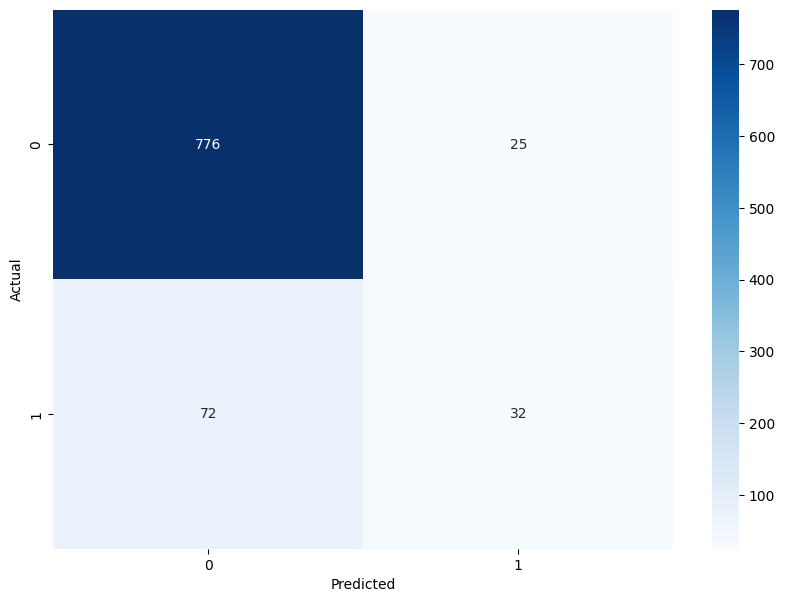

In [47]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# create a heatmap of the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [52]:
# Create a DataFrame of the feature importances
feature_cols = pd.DataFrame(
    zip(train_data.columns, grid_search.best_estimator_.feature_importances_),
    columns=["feature", "importance"])

# Show the top 10 features with most importance
feature_cols.sort_values("importance", ascending=False).head(10)

,feature,importance
7,duration,0.516750
27,poutcome_other,0.225995
38,month_nov,0.059059
9,pdays,0.047756
6,day,0.043875
0,age,0.038617
3,balance,0.024677
35,month_jun,0.014603
25,contact_telephone,0.013665
28,poutcome_success,0.009715


## Model 2: Naive Bayes Classifier

In [56]:
# Define the Gaussian Naive bayes
gnb = GaussianNB()

# Perform cross validation
cross_val_scores = cross_val_score(gnb, X_train, y_train, cv=5, scoring='f1')

# Print the cross-validation scores
print("Cross-Validation Scores:")
for fold, score in enumerate(cross_val_scores, 1):
    print(f"Fold {fold}: {score:.4f}")

# Calculate and print the average accuracy across all folds
average_f1 = cross_val_scores.mean()
print(f"Average f1: {average_f1:.4f}")

Cross-Validation Scores:
Fold 1: 0.3542
Fold 2: 0.3234
Fold 3: 0.4571
Fold 4: 0.4000
Fold 5: 0.3593
Average f1: 0.3788


In [58]:
# Fit the model
gnb.fit(X_train, y_train)

# Evaluate the best model on the train set
y_pred = gnb.predict(X_train)
report = classification_report(y_train, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      3199
           1       0.38      0.40      0.39       417

    accuracy                           0.86      3616
   macro avg       0.65      0.66      0.66      3616
weighted avg       0.86      0.86      0.86      3616



In [60]:
# Evaluate the best model on the test set
X_test = test_data.drop("y", axis=1)
y_test = test_data["y"]
y_pred = gnb.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.92      0.89      0.90       801
           1       0.31      0.38      0.34       104

    accuracy                           0.83       905
   macro avg       0.62      0.64      0.62       905
weighted avg       0.85      0.83      0.84       905



In [61]:
gnb.class_prior_

array([0.8846792, 0.1153208])

# Experiment on the oversampled data

## Method 1: SMOTE

In [74]:
# Create the SMOTE object
smote = SMOTE(sampling_strategy="all", random_state=42)

# Fit and apply SMOTE
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [75]:
y_train_resampled.value_counts()

0    3199
1    3199
Name: y, dtype: int64

In [76]:
# Define the decision tree classifier
decision_tree_clf = DecisionTreeClassifier(random_state=42)

# Define hyperparameters to search over
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a grid search cross-validation object
grid_search = GridSearchCV(decision_tree_clf, param_grid, cv=5)

# Fit the grid search to the data
grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10, 15, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]})

In [77]:
# Get the best hyperparameters
best_params = grid_search.best_params_

# Get the best model
best_model = grid_search.best_estimator_


print(f"The best model is: {best_model}, and the parameters are: \n{best_params}")

The best model is: DecisionTreeClassifier(criterion='entropy', min_samples_split=5,
                       random_state=42), and the parameters are: 
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}


In [79]:
# Evaluate the best model on the train set
y_pred = best_model.predict(X_train_resampled)
report = classification_report(y_train_resampled, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3199
           1       0.99      0.99      0.99      3199

    accuracy                           0.99      6398
   macro avg       0.99      0.99      0.99      6398
weighted avg       0.99      0.99      0.99      6398



In [80]:
# Evaluate the best model on the test set
X_test = test_data.drop("y", axis=1)
y_test = test_data["y"]
y_pred = best_model.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.93      0.89      0.91       801
           1       0.36      0.48      0.41       104

    accuracy                           0.84       905
   macro avg       0.64      0.68      0.66       905
weighted avg       0.86      0.84      0.85       905



In [84]:
# Create a AdaSyn object
adasyn = ADASYN(sampling_strategy="auto", random_state=42, n_neighbors=5, n_jobs=-1)

# Apply ADASYN to balance the dataset
X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)

# Check the distribution
y_train.shape, y_resampled.shape

c:\Users\Not Nabu\.conda\envs\dl_project\lib\site-packages\imblearn\over_sampling\_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


((3616,), (6467,))

In [85]:
# Define the decision tree classifier
decision_tree_clf = DecisionTreeClassifier(random_state=42)

# Define hyperparameters to search over
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a grid search cross-validation object
grid_search = GridSearchCV(decision_tree_clf, param_grid, cv=5)

# Fit the grid search to the data
grid_search.fit(X_resampled, y_resampled)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10, 15, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]})

In [86]:
# Get the best hyperparameters
best_params = grid_search.best_params_

# Get the best model
best_model = grid_search.best_estimator_


print(f"The best model is: {best_model}, and the parameters are: \n{best_params}")

The best model is: DecisionTreeClassifier(max_depth=15, random_state=42), and the parameters are: 
{'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [87]:
# Evaluate the best model on the train set
y_pred = best_model.predict(X_resampled)
report = classification_report(y_resampled, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3199
           1       0.98      0.99      0.99      3268

    accuracy                           0.99      6467
   macro avg       0.99      0.98      0.98      6467
weighted avg       0.99      0.99      0.98      6467



In [88]:
# Evaluate the best model on the test set
X_test = test_data.drop("y", axis=1)
y_test = test_data["y"]
y_pred = best_model.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.94      0.91      0.92       801
           1       0.43      0.55      0.48       104

    accuracy                           0.86       905
   macro avg       0.68      0.73      0.70       905
weighted avg       0.88      0.86      0.87       905



In [89]:
# Save the model
joblib.dump(best_model, "../artifacts/model.pkl")

['../artifacts/model.pkl']